In [3]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [4]:
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import  optim
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
#Hyperparameters
latent_dim = 512
image_size = 128

lr = 2e-5
beta1 = 0.5
beta2 = 0.999

num_epochs = 100
start_warmup = 5
warmup_epoch = 20
batch_size = 16
# Define the mean and std for RGB images
#mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.5, 0.5, 0.5])

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
poke_path = Path('/kaggle/input/pokemon-generation-one-22k')
img_path_list = list(poke_path.glob('*/*/*.jpg'))
len(img_path_list)

22067

In [7]:
# def grayscale_to_rgb(img):
#     if img.shape[0] == 1:  # Grayscale image
#         img = torch.cat([img] * 3, dim=0)  # Repeat the single channel to create an RGB image
#     return img

transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                #transforms.Lambda(grayscale_to_rgb),
                                transforms.Normalize(*stats)
                               ])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


torch.Size([3, 128, 128])


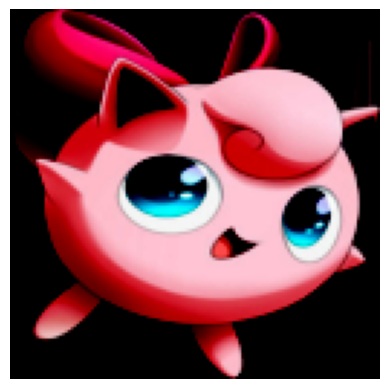

In [59]:
#visualize single image

q = Image.open(random.choice(img_path_list))
q = transform(q)
print(q.shape)
plt.imshow(q.permute(1,2,0))
plt.axis('off')
plt.show()

In [9]:
#preparing the data
class Pokemon(Dataset):
    
    def __init__(self, targ_dir: str):
        #self.paths = targ_dir
        self.paths = list(targ_dir.glob('*/*/*.jpg'))
    
    def load_image(self, index):
        img_path = self.paths[index]
        return Image.open(img_path).convert('RGB')
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        img = transform(img)
        return img

In [10]:
#Dataloader
data = Pokemon(targ_dir=poke_path)
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
len(loader)

1379

In [11]:
#Visualize fn
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for _, images in enumerate(dl):
        show_images(images, nmax)
        break

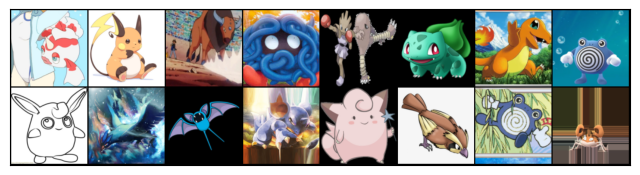

In [12]:
show_batch(loader)

In [13]:
for i, img in enumerate(loader):
    print(img.shape, img.min(), img.max())
    break

torch.Size([16, 3, 128, 128]) tensor(-1.) tensor(1.)


In [14]:
#Model
class Discriminator(nn.Module):
    def __init__(self,  maps=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, maps, 4, 2, 1),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(maps, maps*2 ,4, 2 ,1, bias=False),
            nn.BatchNorm2d(maps*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(maps*2, maps*4, 4, 2 ,1, bias=False),
            nn.BatchNorm2d(maps*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(maps*4, maps*8 ,4, 2 ,1, bias=False),
            nn.BatchNorm2d(maps*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(maps*8, maps*16 ,4, 2 ,1, bias=False),
            nn.BatchNorm2d(maps*16),
            nn.LeakyReLU(0.2, ),
        )
        self.outputs = nn.Sequential(nn.Conv2d(maps*16, 1, 4, 1, 0),
                                     nn.Flatten(),
                                     nn.Sigmoid())
    
    def forward(self, x):
        return self.outputs(self.features(x))

dis = Discriminator().to(device)
summary(dis, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

In [15]:
class Generator(nn.Module):
    def __init__(self, maps=64 ,noise=128):
        super().__init__()
        self.model = nn.Sequential(
        nn.ConvTranspose2d(noise, 16*maps, 4, 1, 0, bias=False),
        nn.BatchNorm2d(maps*16),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(16*maps, maps*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(maps*8),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(8*maps, maps*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(maps*4),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(4*maps, maps*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(maps*2),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(2*maps, maps, 4, 2, 1, bias=False),
        nn.BatchNorm2d(maps),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(maps, 3, 4 ,2 ,1),
        nn.Tanh()
        )
    def forward(self, z):
        #z = z.view(-1, 128, 1, 1)
        return self.model(z)
    
gen = Generator(noise=latent_dim).to(device)
summary(gen, (512,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       8,388,608
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [16]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = gen(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    torchvision.utils.save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [18]:
MODEL_PATH = Path("saved-weights")
# MODEL_PATH.mkdir(parents=True, # create parent directories if needed
#                  exist_ok=True # if models directory already exists, don't error
# )


In [19]:
#Loading state dict#################
dis_path = '/kaggle/input/saved-weights/dis135.pth'
gen_load = Discriminator().to(device)
gen_load.load_state_dict(torch.load(f=dis_path, map_location=device))

<All keys matched successfully>

In [20]:
#Loading state dict#################
gen_path = '/kaggle/input/saved-weights/gen135.pth'
gen_load = Generator(noise = 512).to(device)
gen_load.load_state_dict(torch.load(f=gen_path, map_location=device))

<All keys matched successfully>

In [43]:
fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# torch.cuda.empty_cache()
# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
     
    
# Create optimizers
opt_d = torch.optim.Adam(dis.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    
for epoch in tqdm(range(num_epochs)):
    for _, real_images in enumerate(loader):
        if start_warmup < epoch < warmup_epoch:
            # Train generator
            # Clear generator gradients
            opt_g.zero_grad()
    
            # Generate fake images
            latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = gen(latent)
    
            # Try to fool the discriminator
            preds = dis(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = F.binary_cross_entropy(preds, targets)
    
            # Update generator weights
            loss_g.backward()
            opt_g.step()
            
            loss_d, real_score, fake_score = 0.0, 0.0, 0.0
        else:
            ########## Train discriminator
            opt_d.zero_grad()

            # Pass real images through discriminator
            real_images = real_images.to(device)
            real_preds = dis(real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = F.binary_cross_entropy(real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
    
            # Generate fake images
            latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = gen(latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = dis(fake_images)
            fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            opt_d.step()
    
            ########## Train generator
            opt_g.zero_grad()
            # Generate fake images
            latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = gen(latent)
    
            # Try to fool the discriminator
            preds = dis(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = F.binary_cross_entropy(preds, targets)
    
            # Update generator weights
            loss_g.backward()
            opt_g.step()            
    
    if start_warmup < epoch < warmup_epoch:
        # Record losses & scores
        losses_g.append(loss_g.item())
    else:
        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
    # Log losses & scores (last batch)
    if epoch % 5 == 0: 
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch, num_epochs, loss_g, loss_d, real_score, fake_score))
        # Create model save path
        GEN_NAME = f"gen{epoch}.pth"
        GEN_SAVE_PATH = MODEL_PATH / GEN_NAME
        DIS_NAME = f"dis{epoch}.pth"
        DIS_SAVE_PATH = MODEL_PATH / DIS_NAME


        # Save the model state dict
        print(f"Saving model to: {GEN_SAVE_PATH}")
        torch.save(obj=gen.state_dict(), # only saving the state_dict() only saves the learned parameters
                   f=GEN_SAVE_PATH)

        print(f"Saving model to: {DIS_SAVE_PATH}")
        torch.save(obj=dis.state_dict(), # only saving the state_dict() only saves the learned parameters
                   f=DIS_SAVE_PATH)
        # Save generated images
        save_samples(epoch, fixed_latent, show=False)

In [53]:
q = Path('/kaggle/working/models/gen135.pth')
gen_load = Generator(noise = 512).to(device)
gen_load.load_state_dict(torch.load(f=gen_path, map_location=device))

<All keys matched successfully>

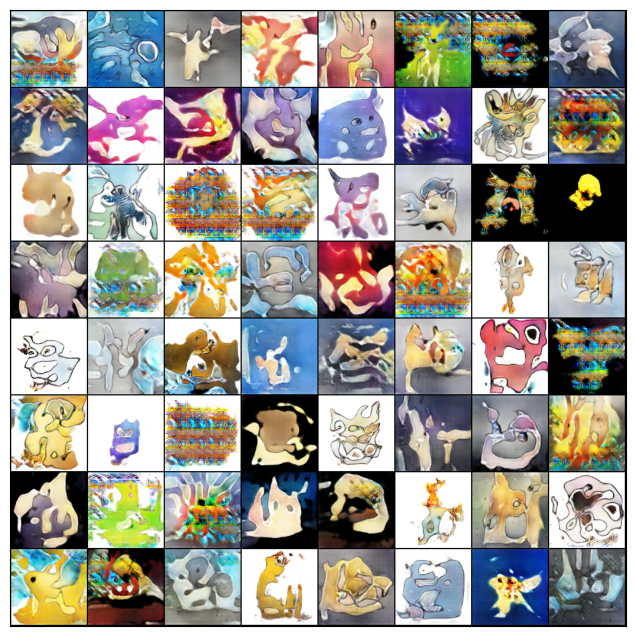

In [67]:
#Inference#########################
fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)
with torch.inference_mode():
    gen_images = gen_load(fixed_latent)
    show_images(gen_images.cpu())


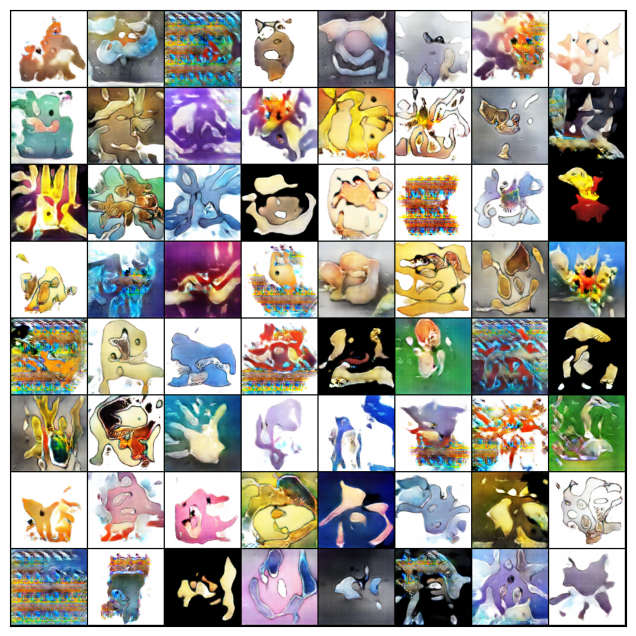

In [68]:
#Inference#########################
fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)
with torch.inference_mode():
    gen_images = gen_load(fixed_latent)
    show_images(gen_images.cpu())
